# DIY candy counter
https://huggingface.co/docs/transformers/tasks/object_detection#inference

In [ ]:
# collect all the installations
! pip install datasets
! pip install transformers
! pip install timm
! pip install accelerate -U
! pip install transformers[torch]

## Load the candy_data dataset

In [23]:
import json
with open('result.json') as f:
  cocodata = json.load(f)

In [24]:
# Store Huggingface formated data in a list
huggingdata = []
# Iterate through the images
for image in cocodata['images']:
  # Remove the image directory from the file name
  image['file_name'] = image['file_name'].split('/')[-1]
  image['image_id'] = image['id']
  # Extend the image dict with bounding boxes and class labels
  image['objects'] = {'bbox': [], 'category': [], 'area': [], 'id': []}
  # Iterate through the annotations (bounding boxes and labels)
  for annot in cocodata['annotations']:
    # Check if the annotation matches the image
    if annot['image_id'] == image['id']:
      # Add the annotation
      image['objects']['bbox'].append(annot['bbox'])
      image['objects']['category'].append(annot['category_id'])
      image['objects']['area'].append(annot['area'])
      image['objects']['id'].append(annot['id'])
  # Append the image dict with annotations to the list
  huggingdata.append(image)

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
with open("metadata.jsonl", 'w') as f:
  for item in huggingdata:
    f.write(json.dumps(item) + "\n")

In [27]:
from datasets import load_dataset
candy_data = load_dataset('imagefolder', data_dir="data")
# Assumes the data is stored in a folder called "data".

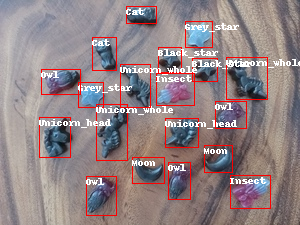

In [28]:
# visualize an example
import numpy as np
import os
from PIL import Image, ImageDraw

image = candy_data["train"][0]["image"]
annotations = candy_data["train"][0]["objects"]
draw = ImageDraw.Draw(image)

id2label = {item['id']: item['name'] for item in cocodata['categories']}
label2id = {v: k for k, v in id2label.items()}

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i]
    class_idx = annotations["category"][i]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
    draw.text((x, y), id2label[class_idx], fill="white")

image

## Preprocess the data using DETR Model

In [29]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [30]:
import albumentations
import numpy as np
import torch

# image augmentation: resize, horizontal flip and brighten
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

In [31]:
# reformat the annotations for a single example
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [32]:
# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [33]:
# check what an example from the dataset should look like
candy_data["train"] = candy_data["train"].with_transform(transform_aug_ann)
candy_data["train"][9]



{'pixel_values': tensor([[[ 0.4851,  0.4851,  0.4851,  ...,  0.1597,  0.1597,  0.1597],
          [ 0.4851,  0.4851,  0.4851,  ...,  0.1597,  0.1597,  0.1597],
          [ 0.4851,  0.4851,  0.4851,  ...,  0.1597,  0.1597,  0.1597],
          ...,
          [-0.0629, -0.0629, -0.0629,  ..., -0.1828, -0.1828, -0.1828],
          [-0.0629, -0.0629, -0.0629,  ..., -0.1828, -0.1828, -0.1828],
          [-0.0629, -0.0629, -0.0629,  ..., -0.1828, -0.1828, -0.1828]],
 
         [[ 0.6779,  0.6779,  0.6779,  ...,  0.2927,  0.2927,  0.2927],
          [ 0.6779,  0.6779,  0.6779,  ...,  0.2927,  0.2927,  0.2927],
          [ 0.6779,  0.6779,  0.6779,  ...,  0.2927,  0.2927,  0.2927],
          ...,
          [ 0.1527,  0.1527,  0.1527,  ..., -0.0399, -0.0399, -0.0399],
          [ 0.1527,  0.1527,  0.1527,  ..., -0.0399, -0.0399, -0.0399],
          [ 0.1527,  0.1527,  0.1527,  ..., -0.0399, -0.0399, -0.0399]],
 
         [[ 0.8622,  0.8622,  0.8622,  ...,  0.5136,  0.5136,  0.5136],
          [ 

In [34]:
# batch images together
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Training the DETR model

In [35]:
# load the model using the same checkpoint as in the preprocessing
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [49]:
# create training arguments
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="detr-resnet-50_finetuned_candy_detector", #renamed
    per_device_train_batch_size=8,
    num_train_epochs=400, #changed from 10
    fp16=True,
    save_steps=200,
    logging_steps=50, #changed from 50
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False, #changed from True to avoid pushing to HF hub
)

In [50]:
!git config --global credential.helper store
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: read).
Your token has been saved in your 

In [51]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=candy_data["train"],
    tokenizer=image_processor,
)

trainer.train()

Step,Training Loss
50,1.433000
100,1.254000
150,1.103900
200,0.983100
250,0.892800
300,0.817100
350,0.753600
400,0.702200
450,0.656500
500,0.620100


TrainOutput(global_step=800, training_loss=0.7814129948616028, metrics={'train_runtime': 759.5856, 'train_samples_per_second': 5.793, 'train_steps_per_second': 1.053, 'total_flos': 2.102428601856e+18, 'train_loss': 0.7814129948616028, 'epoch': 400.0})

## Save the Model

In [52]:
trainer.save_model('candy_detector')

## Access the Model

In [1]:
def candy_counter(image):

    required_width, required_height = 300, 225
    
    if image.size == (required_width, required_height):

        from transformers import pipeline
        obj_detector = pipeline("object-detection", model="candy_detector")

        dict = obj_detector(image, threshold=0.20)

        label_counts = {}
        for entry in dict:
            label = entry['label']
            if label in label_counts:
                label_counts[label] += 1
            else:
                label_counts[label] = 1

        draw = ImageDraw.Draw(image)

        for item in dict:
            label = item['label']
            box = item['box']

            x, y, x2, y2 = box['xmin'], box['ymin'], box['xmax'], box['ymax']
            draw.rectangle(((x, y), (x2, y2)), outline="blue", width=1)
            draw.text((x, y), label, fill="white")

    else:
        print("Image dimensions are not 225x300 pixels.")

    return label_counts, image

In [2]:
# provide a file path
from PIL import Image, ImageDraw
image = Image.open("test_image.jpg")

In [3]:
label_counts, processed_image = candy_counter(image)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
label_counts

{'Unicorn_head': 3, 'Black_star': 5, 'Unicorn_whole': 3, 'Insect': 2, 'Owl': 1}

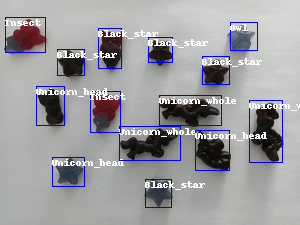

In [5]:
processed_image